## Figure 6: Fitting a 3-State GLM-HMM to Real Data

This notebook recreates the figure panels included in Figure 6 of [Bolkan, Stone et al 2021](https://www.biorxiv.org/content/10.1101/2021.07.23.453573v1). It also serves as a useful tutorial notebook for users who might want to fit GLM-HMMs to their own experimental data. For a more generic example of how GLM-HMMs can be applied to simulated data, check out the <code>fit-glm-hmm.ipynb</code> notebook in the <code>examples</code> folder.

The general premise of this notebook/figure, in the context of the paper, is that we have determined that a 3-state GLM-HMM performs better at describing our data than a standard GLM (see <code>fig5.ipynb</code> for more details). Below, we fit this 3-state GLM-HMM to our experimental datasets, explore some of the fitted model parameters in order to interpret the results, and provide further verification that this model descibes our data well. 

------------------
#### Description of the Data

The real data that we will use in this case comes from the experiments described in [Bolkan, Stone et al 2021](https://www.biorxiv.org/content/10.1101/2021.07.23.453573v1). This is behavioral data from mice performing a two alternative forced choice (2AFC) task in which the animals run down a virtual maze while multi-sensory "cues" appear to their left and right. The mice must "accumulate evidence" as these cues appear and ultimately make a decision to turn left or right based on which side of the maze had more cues.

The dataset in the paper includes three cohorts of mice: a group that was inhibited in the direct pathway of the striatum, a group that was inhibited in the indirect pathway, and a control (no opsin) group. Below we fit a GLM and GLM-HMM to the two inhibition groups, but you can modify the code below to fit the models to the control group as well.

The provided design matrices (loaded below) includes values for the following external covariates (in this order): 
<ul>
    <li><b>bias:</b> the offset or intercept term</li>
    <li><b>delta cues:</b> the standardized difference in the number of cues that appear on the right (R) and left (L) sides of the maze (coded as R-L)</li>
    <li><b>laser:</b> the on/off status of the laser on each trial, indicating whether striatal inhibition occured</li>
    <li><b>previous choices 1-6:</b> the choice that the animal made on the previous trial (and up to six trials ago)</li>
    <li><b>previous rewarded choice</b> the choice that the animal made on the previous trial and whether or not that choice was rewarded</li>
     
</ul>
See the methods section of the paper for more information on how we coded these covariates. 

The <code>data</code> folder also includes date information for each cohort, indicating whether each trial was conducted on an odd numbered date (denoted by a $-1$), or an even numbered date (denoted by a $1$). This is pertinent because it tells us whether inhibition occured in the right hemisphere (even dates) or the left hemisphere (odd dates) for each trial.

------------------
###  Import the required code packages and modules.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from glmhmm import glm_hmm
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm.visualize import plot_loglikelihoods, plot_weights

### Fit the GLM-HMMs

#### Load the data

In [2]:
# load the data for the indirect pathway cohort
x_d2 = np.load('data/indirect_x.npy') # z-scored design matrix
y_d2 = np.load('data/indirect_y.npy') # vector of right and left choices for each trial
sessions_d2 = np.load('data/indirect_sessions.npy') # vector of session start and stop indices

# load the data for the direct pathway cohort
x_d1 = np.load('data/direct_x.npy') # z-scored design matrix
y_d1 = np.load('data/direct_y.npy') # vector of right and left choices for each trial
sessions_d1 = np.load('data/direct_sessions.npy') # vector of session start and stop indices

#### Set the hyperparameters

In [3]:
N_d2 = x_d2.shape[0] # number of data/time points for the indirect pathway cohort
N_d1 = x_d1.shape[0]
K = 3 # number of latent states
C = 2 # number of observation classes
D = x_d2.shape[1] # number of GLM inputs (regressors)

#### Fit using multiple initializations

In this case, we're going to initialize the weights by fitting a GLM to the data. Once we have the fitted GLM weights (you can think of this as a 1-state GLM-HMM), we'll duplicate those weights $K$ times and add a small amount noise to each set. These weights will then form our $w_{init}$ and serve as a smarter initialization that will help us find the best solution more quickly and more often than if we initialized the weights randomly.

This case will also be different from the simulated example (see <code>fit-glm-hmm.ipynb</code>) in that now the structure of our data includes different sessions, consisting of different mice performing the task on different days. So that the fitted parameters aren't affected by this structure (i.e. the last trial on one day doesn't affect the first trial on the next day) we will fit separately to each session. Fortunately, this is easy to do -- we simply include a vector with the first and last indices of each session length as an extra input to the fitting code.

<b>Note:</b> To illustrate the process of confirming we've found the global optimum (see step 4), the code below fits the model 20 times. This can take 1-2.5 hours to run, depending on your machine. For a quicker assessment, reduce the number of inits. 

In [4]:
inits = 20 # set the number of initializations
maxiter = 250 # maximum number of iterations of EM to allow for each fit
tol = 1e-3

## indirect pathway cohort --------------------------------------------------------

# store values for each initialization
lls_all_d2 = np.zeros((inits,250))
real_GLMHMMs_d2 = np.zeros((inits),dtype=object)

# fit the model for each initialization
for i in range(inits):
    real_GLMHMMs_d2[i] = glm_hmm.GLMHMM(N_d2,D,C,K,observations="bernoulli",gaussianPrior=1)
    # initialize the weights
    A_init,w_init,_ = real_GLMHMMs_d2[i].generate_params(weights=['GLM',-0.2,1.2,x_d2,y_d2,1])
    # fit the model                     
    lls_all_d2[i,:],_,_,_ = real_GLMHMMs_d2[i].fit(y_d2,x_d2,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessions_d2) 
    
## direct pathway cohort ----------------------------------------------------------

# store values for each initialization
lls_all_d1 = np.zeros((inits,250))
real_GLMHMMs_d1 = np.zeros((inits),dtype=object)

# fit the model for each initialization
for i in range(inits):
    real_GLMHMMs_d1[i] = glm_hmm.GLMHMM(N_d1,D,C,K,observations="bernoulli",gaussianPrior=1)
    # initialize the weights
    A_init,w_init,_ = real_GLMHMMs_d1[i].generate_params(weights=['GLM',-0.2,1.2,x_d1,y_d1,1])
    # fit the model                     
    lls_all_d1[i,:],_,_,_ = real_GLMHMMs_d1[i].fit(y_d1,x_d1,A_init,w_init,maxiter=maxiter,tol=tol,sess=sessions_d1) 

#### Check to see that multiple fits achieve the same log-likelihood

Since we're now fitting real data, we can't simply compare our inferred parameters to the true ones to make sure we're recovering the right values. But we can get a reasonable assessment of whether or not we're finding the global optimum of the log-likelihood by comparing the log-likelihoods for each fit. If multiple log-likelihoods for the best fits converge to the same (or very similar) values, this is a good indication that we've found the global optimum.

Number of top matching lls within threshold for indirect pathway:  7
Number of top matching lls within threshold for direct pathway:  13


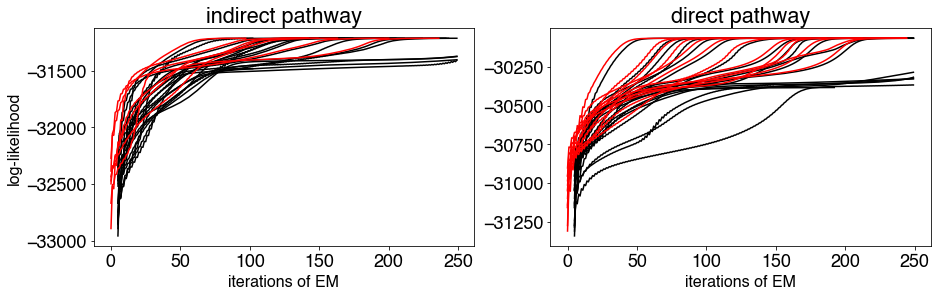

In [43]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 4)
topixs_d2 = plot_loglikelihoods(lls_all_d2,0.15,axes[0],startix=5)
axes[0].set_title('indirect pathway')
topixs_d1 = plot_loglikelihoods(lls_all_d1,0.15,axes[1],startix=5)
axes[1].set_title('direct pathway')
axes[1].set_ylabel('')
print('Number of top matching lls within threshold for indirect pathway: ', len(topixs_d2))
print('Number of top matching lls within threshold for direct pathway: ', len(topixs_d1))

#### We can also check that the weights for the best fits are the same, within some tolerance

In [44]:
# permute the weights according to the value of a particular regressor (here we pick cues, located in the 
# first column of the design matrix, thus ix=1) so that the states will be the same for each fit 
np.set_printoptions(precision=2,suppress=True)

## indirect pathway cohort --------------------------------------------------------
w_permuted_d2 = np.zeros((inits,K,D))
order_d2 = np.zeros((inits,K))
for i in range(inits):
    w_permuted_d2[i],order_d2[i] = permute_states(real_GLMHMMs_d2[i].w[:,:,1],method='weight value',
                                                  param='weights',ix=1)
compare_top_weights(w_permuted_d2,topixs_d2,tol=0.5)

## direct pathway cohort --------------------------------------------------------
w_permuted_d1 = np.zeros((inits,K,D))
order_d1 = np.zeros((inits,K))
for i in range(inits):
    w_permuted_d1[i],order_d1[i] = permute_states(real_GLMHMMs_d1[i].w[:,:,1],method='weight value',
                                                  param='weights',ix=1)
compare_top_weights(w_permuted_d1,topixs_d1,tol=0.5)

None of the weights differ by more than the set tolerance. The largest difference was 0.01.
This confirms that the top fits (as specified) all converged on the same solution.
None of the weights differ by more than the set tolerance. The largest difference was 0.01.
This confirms that the top fits (as specified) all converged on the same solution.


Before we continue, let's save our fit GLM-HMM model objects for the initializations that produced the best fit. This will allow us to load the objects (and by extension, the inferred parameters stored in those objects) in other notebooks. This will be useful for generating other plots related to these model fits without having to run the fitting code from scratch.

In [66]:
import pickle
bestix_d2 = find_best_fit(lls_all_d2) # find the initialization that led to the best fit
best_GLMHMM_d2 = real_GLMHMMs_d2[bestix_d2]
pickle.dump(best_GLMHMM_d2, open('fit models/GLMHMM_d2.pickle', 'wb'))
bestix_d1 = find_best_fit(lls_all_d1) # find the initialization that led to the best fit
best_GLMHMM_d1 = real_GLMHMMs_d1[bestix_d1]
pickle.dump(best_GLMHMM_d1, open('fit models/GLMHMM_d1.pickle', 'wb'))

### Fig 6A/B: Plot the inferred weights

In the plot of the weights below, we include error bars on each of the weights. We computed the variance for this purpose by taking the inverse Hessian of the optimized log-likelihood. This is a process that relies on autograd and is somewhat slow, so if you're running this notebook yourself and looking for a quick visualization, we recommend skipping that step (and changing the inputs in the <code>plot_weights</code> function to <code>error=None</code>). 

In [ ]:
# compute the error bars
A_permuted, _ = permute_states(best_GLMHMM_d2.A,method='order',order=order[bestix_d2].astype(int))
variance_d2 = best_GLMHMM_d2.computeVariance(x,y,A_permuted,w_permuted_d2[bestix_d2,:,:,np.newaxis],gaussPrior=1)
A_permuted, _ = permute_states(best_GLMHMM_d2.A,method='order',order=order[bestix_d1].astype(int))
variance_d1 = best_GLMHMM_d1.computeVariance(x,y,A_permuted,w_permuted_d1[bestix_d1,:,:,np.newaxis],gaussPrior=1)

Text(0.5, 1.0, 'direct pathway')

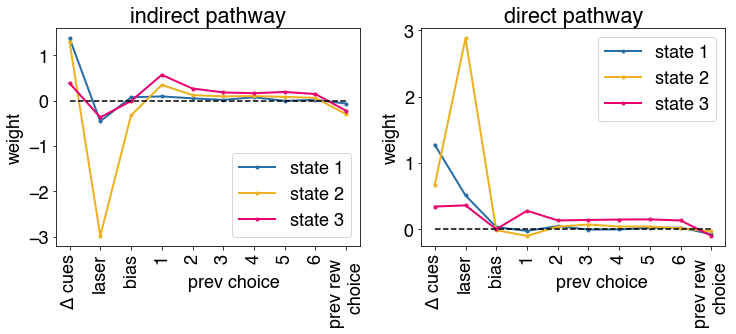

In [65]:
# plot the inferred weights probabilities
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12, 4)
colors = np.array([[39,110,167],[237,177,32],[233,0,111],[176,100,245]])/255
xlabels = ['$\Delta$ cues', 'laser', 'bias', '1', '2', '3', '4', '5', '6', 'prev rew \n choice']
legend = ['state 1', 'state 2', 'state 3']
plot_weights(w_permuted_d2[bestix_d2],axes[0],xlabels=xlabels,switch=True,style='.-',
             color=colors,error=None,label=legend)
axes[0].text(0.40,0.05,'prev choice',transform=ax.transAxes)
axes[0].legend()
axes[0].set_title('indirect pathway')
plot_weights(w_permuted_d1[bestix_d1],axes[1],xlabels=xlabels,switch=True,style='.-',
             color=colors,error=None,label=legend)
axes[1].text(1.5,0.05,'prev choice',transform=ax.transAxes)
axes[1].legend()
axes[1].set_title('direct pathway')

### Fig 6C-F: Plot the psychometric curves for real and simulated data

To verify that the 3-state GLM-HMM provides a good explanation of the real data, we'll now simulate data from the fit models and then plot psychometric curves for both the real and simulated data to see how well they match. To best visualize this, we'll plot the psychometric curves separately for the subset of data associated with each internal state. 

In [75]:
# simulate data from indirect pathway cohort
sim_x_d2,sim_y_d2,sim_z_d2 = best_GLMHMM_d2.generate_data_from_fit(best_GLMHMM_d2.w,best_GLMHMM_d2.A,
                                                                   x_d2,obs_ix=[3,9],
                                                                   replace_obs=True,
                                                                   sessions=sessions_d2)
# simulate data from direct pathway cohort
sim_x_d1,sim_y_d1,sim_z_d1 = best_GLMHMM_d1.generate_data_from_fit(best_GLMHMM_d1.w,best_GLMHMM_d1.A,
                                                                   x_d1,obs_ix=[3,9],
                                                                   replace_obs=True,
                                                                   sessions=sessions_d1)

To plot separate psychometric curves for the "laser on" and "laser off" trials using a "contra - ipsi" y-axis, we'll need to convert the choices on inhibition trials for one hemisphere. Because the hemisphere of inhibition is determined by the date of the behavior session (even or odd dates), we'll also need to load that information.
In order to have the right x-axis, we'll also want the actual delta cues (not standardized). To get these values, we simply need to multiply the standardized delta cues by the standard deviation of the original values, which happens to be 6.5.

In [119]:
from glmhmm.utils import convertContraIpsi

# load date information
dates_d2 = np.load('data/indirect_dates.npy')
dates_d1 = np.load('data/direct_dates.npy')

## indirect pathway cohort --------------------------------------------------------
# convert to contra-ipsi (real data)
for i in range(K):
    save_path = 'matlab/psychometric_data_d2_state_%s.mat' %(i+1)
    state_ix = np.where(best_GLMHMM_d2.states == order_d2[bestix_d2][i])[0] # take possible permutation into account
    dict_real = convertContraIpsi(x_d2[state_ix,2], x_d2[state_ix,1], y_d2[state_ix], dates_d2[state_ix], 
                                  save_path,scale=6.5)
# convert to contra-ipsi (simulated data)
for i in range(K):
    save_path = 'matlab/psychometric_simulated_d2_state_%s.mat' %(i+1)
    state_ix = np.where(sim_z_d2 == order_d2[bestix_d2][i])[0] # take possible permutation into account
    dict_real = convertContraIpsi(x_d2[state_ix,2], x_d2[state_ix,1], sim_y_d2[state_ix], dates_d2[state_ix], 
                              save_path,scale=6.5)

## direct pathway cohort --------------------------------------------------------
# convert to contra-ipsi (real data)
for i in range(K):
    save_path = 'matlab/psychometric_data_d1_state_%s.mat' %(i+1)
    state_ix = np.where(best_GLMHMM_d1.states == order_d1[bestix_d1][i])[0] # take possible permutation into account
    dict_real = convertContraIpsi(x_d1[state_ix,2], x_d1[state_ix,1], y_d1[state_ix], dates_d1[state_ix], 
                                  save_path,scale=6.5)
# convert to contra-ipsi (simulated data)
for i in range(K):
    save_path = 'matlab/psychometric_simulated_d1_state_%s.mat' %(i+1)
    state_ix = np.where(sim_z_d1 == order_d1[bestix_d1][i])[0] # take possible permutation into account
    dict_real = convertContraIpsi(x_d1[state_ix,2], x_d1[state_ix,1], sim_y_d1[state_ix], dates_d1[state_ix], 
                              save_path,scale=6.5)

Now we have everything we need to plot the psychometric curves. <b>Note:</b> To run this locally, you'll need to have a copy of MATLAB 2019b as well as the MATLAB Engine API for Python installed on your computer (see more info [here](https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)).

In [120]:
from glmhmm.visualize import plot_psychometrics
import ipywidgets as widgets
import IPython.display as display

colors = np.array([[39,110,167],[237,177,32],[233,0,111]])/255
lb = [[1e-6 1e-6 -inf -inf];[1e-6 1e-6 -inf -inf]]
ub = [[0.75 0.75 inf inf];[0.75 0.75 inf inf]]
title = ['state 1', 'state 2', 'state 3']
path_string = 'matlab/psychometric'
types = ['data', 'simulated']
cohorts = ['d2','d1']

for typ in types: # for each type (real or simulated data)
    wi = []
    for cohort in cohorts: # for each cohort (d2 or d1)
        for i in range(K): # for each state 
            state_colors = [list(colors[i]),list(colors[i])]
            file_path = '%s_%s_%s_state_%s.mat' %(path_string, typ, cohort, i+1)
            save_path = '%s_%s_%s_state_%s.png' %(path_string, typ, cohort, i+1)
            plot_psychometrics(state_colors,title[i],file_path,save_path,lb=lb,ub=ub)
            img = open('%s_%s_%s_state_%s.png' %(path_string, typ, cohort, i+1), 'rb').read()
            wi_real.append(widgets.Image(value=img, format='png', width=150, height=75))
    # display saved matlab plots inline
    display.display(widgets.HBox([wi[0],wi[1],wi[2],wi[3],wi[4],wi[5]]))

We can see from these plots that the psychometrics for the real (top) and simulated (bottom) data match much more closely than they did for the standard GLM (see <code>fig4.ipynb</code>). Thus, we can feel confident that the results we get from the GLM-HMM provide an accurate description of our experimental datasets.

We'll need a few more things for the remaining plots in this figure, so let's grab all of that info now.

In [150]:
# permute the order of the states
state_permuted_d2,_ = permute_states(best_GLMHMM_d2.states,method='order',param='states',
                                   order=order[bestix_d2].astype(int))
state_permuted_d1,_ = permute_states(best_GLMHMM_d1.states,method='order',param='states',
                                   order=order[bestix_d2].astype(int))

# load additional data
mouseIDs_d2 = np.load('data/indirect_mouseIDs.npy')
trialTypes_d2 = np.load('data/indirect_trialTypes.npy')
mouseIDs_d1 = np.load('data/direct_mouseIDs.npy')
trialTypes_d1 = np.load('data/direct_trialTypes.npy')

### Fig 6G: Check performance in each state

Text(0.5, 1.0, 'direct')

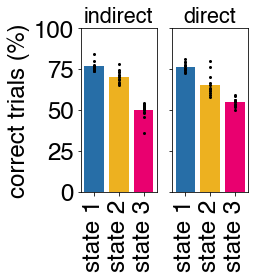

In [158]:
from glmhmm.visualize import plot_state_performance

fig, axes = plt.subplots(1,2)
fig.set_size_inches(3,3)
plot_state_performance(y_d2,state_permuted_d2,trialTypes_d2,mouseIDs_d2,colors,axes[0])
axes[0].set_title('indirect')
plot_state_performance(y_d1,state_permuted_d1,trialTypes_d1,mouseIDs_d1,colors,axes[1])
axes[1].set_yticklabels('')
axes[1].set_ylabel('')
axes[1].set_title('direct')

### Fig 6H: Check the percentage of laser trials in each state

Text(0.5, 1.0, 'direct')

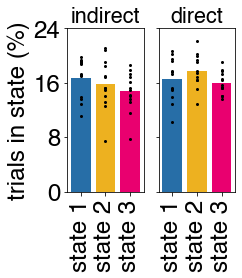

In [162]:
from glmhmm.visualize import plot_percent_laser_trials

fig, axes = plt.subplots(1,2)
fig.set_size_inches(3,3)
plot_percent_laser_trials(state_permuted_d2,x_d2[:,2],mouseIDs_d2,colors,axes[0])
axes[0].set_title('indirect')
plot_percent_laser_trials(state_permuted_d1,x_d1[:,2],mouseIDs_d1,colors,axes[1])
axes[1].set_yticklabels('')
axes[1].set_ylabel('')
axes[1].set_title('direct')

### Fig 6I: Check that the laser doesn't generate transitions between states 

Text(0.5, 1.0, 'direct pathway')

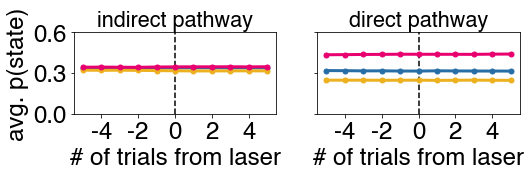

In [173]:
from glmhmm.visualize import plot_triggered_average

fig, axes = plt.subplots(1,2)
fig.set_size_inches(8,1.5)
plot_triggered_average(state_permuted_d2,x_d2[:,2],colors,axes[0])
axes[0].set_title('indirect pathway')
plot_triggered_average(state_permuted_d1,x_d1[:,2],colors,axes[1])
axes[1].set_yticklabels('')
axes[1].set_ylabel('')
axes[1].set_title('direct pathway')